<a href="https://colab.research.google.com/github/Omarosh/covid/blob/main/Project_Xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Now to download the dataset from kaggle to colab

In [15]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle/

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

In [ ]:
!ls

In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

In [3]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle/COVID-19 Radiography Database/

/content/gdrive/My Drive/Kaggle/COVID-19 Radiography Database


Start

In [6]:
import numpy as np
import pandas as pd
import torch

from torchvision.datasets import ImageFolder
from torchvision import transforms

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

import torch.optim as optim

import cv2

from sklearn import metrics
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
from random import shuffle
import os
import shutil

import random
%matplotlib inline

In [7]:
datadir = os.getcwd()
covid='/content/gdrive/My Drive/Kaggle/COVID-19 Radiography Database/COVID/'
normal='/content/gdrive/My Drive/Kaggle/COVID-19 Radiography Database/NORMAL/'
pneumonia='/content/gdrive/My Drive/Kaggle/COVID-19 Radiography Database/Viral Pneumonia/'

In [65]:
datadir

'/content/gdrive/My Drive/Kaggle/COVID-19 Radiography Database'

In [8]:
data = []
labels = []
folderlist = os.listdir()
print(folderlist)
for dir in folderlist:
    os.chdir(dir)
    currentDir = os.getcwd()
    images = os.listdir()
    paths = [os.path.abspath(path) for path in images]
    data = data + paths
    labels = labels + len(paths)*[dir]
    os.chdir("..")


['COVID', 'NORMAL', 'Viral Pneumonia']


In [9]:
xtrain,xtest,ytrain,ytest = train_test_split(data,labels,test_size=0.4,random_state=1)

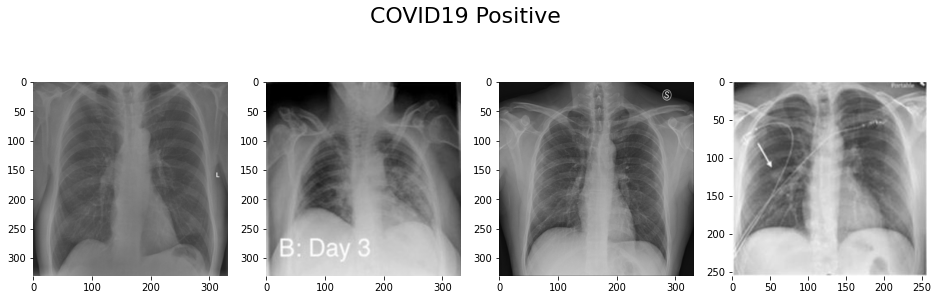

In [10]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(covid)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(covid, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

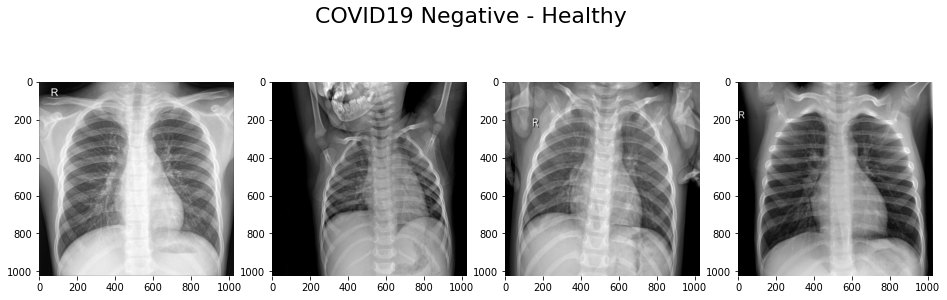

In [101]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(normal)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(normal, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [11]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), #Resizes all images into same dimension
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [13]:
def load_split_train_test(datadirectory, valid_size = .2):
    train_data = datasets.ImageFolder(datadirectory,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    test_data = datasets.ImageFolder(datadirectory,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(datadir, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)
dataset_size

['COVID', 'NORMAL', 'Viral Pneumonia']


{'train': 3109, 'val': 777}

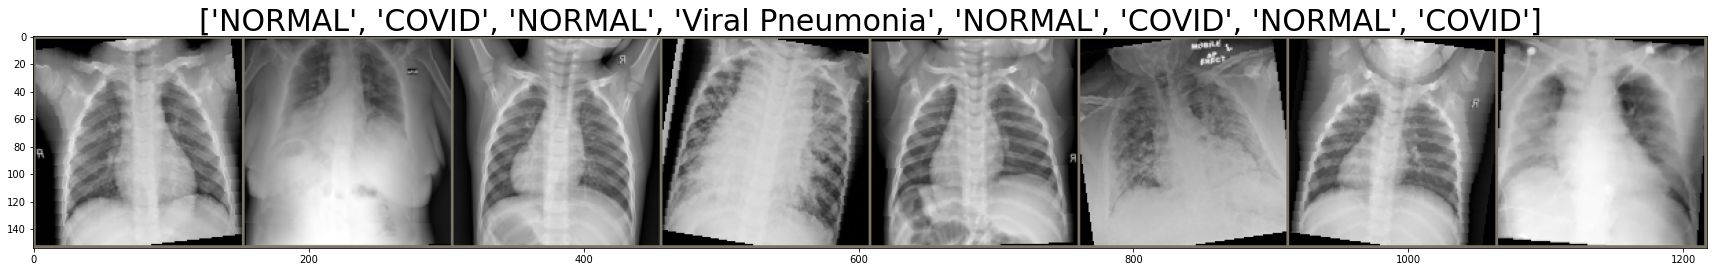

In [14]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

GPU

In [15]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...
